[]

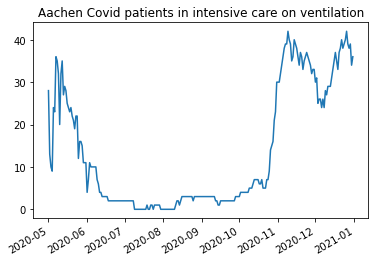

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# just a utility function ignore that
def get_df_name(df):

    name =[x for x in globals() if globals()[x] is df][0]
    return name

# read the Aachen Intensive Care dataset
aachen = pd.read_csv('Intensive_Care_Aachen_2020.csv', index_col='daten_stand', parse_dates=True)

# preprocessing
aachen = aachen.drop(['gemeindeschluessel', 'bundesland', 'anzahl_meldebereiche'], axis=1)

plt.plot(aachen.faelle_covid_aktuell_beatmet)
plt.title("Aachen Covid patients in intensive care on ventilation")
# solves overlapping dates on x-axis
plt.gcf().autofmt_xdate()
plt.plot()

In [2]:
#define function for ADF test

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] < 0.05 :
        print('p-value: ' + str(dftest[1]) + ' < 0.05 => the series is stationary')
    else:
        print('p-value: ' + str(dftest[1]) + ' > 0.05 => the series is non-stationary')

# define function for KPSS test

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags='legacy')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)' % key] = value
    print(kpss_output)
    if kpsstest[1] < 0.05 :
        print('p-value: ' + str(kpsstest[1]) + ' < 0.05 => the series is non-stationary')
    else:
        print('p-value: ' + str(kpsstest[1]) + ' > 0.05 => the series is stationary')

In [3]:
# run an augmented Dicky-Fuller test on the 'faelle_covid_aktuell_beatmet' series
adf_test(aachen['faelle_covid_aktuell_beatmet'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.386011
p-value                          0.588964
#Lags Used                      16.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64
p-value: 0.588964173846014 > 0.05 => the series is non-stationary


In [4]:
# run a kpss test on the 'faelle_covid_aktuell_beatmet' series
kpss_test(aachen['faelle_covid_aktuell_beatmet'])

Results of KPSS Test:
Test Statistic            0.658107
p-value                   0.017354
Lags Used                16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
p-value: 0.01735386455181047 < 0.05 => the series is non-stationary


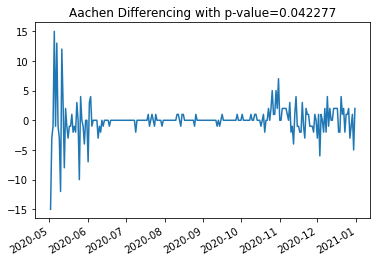

In [5]:
# Trying to transform to stationary time series by taking the difference
aachen_stationary = aachen.diff().dropna()
plt.plot(aachen_stationary.faelle_covid_aktuell_beatmet)
plt.title("Aachen Differencing with p-value=0.042277")
plt.gcf().autofmt_xdate()
plt.show()

In [6]:
# run an augmented Dicky-Fuller test to see if stationary transformation succeeded
adf_test(aachen_stationary['faelle_covid_aktuell_beatmet'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.927180
p-value                          0.042277
#Lags Used                      15.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64
p-value: 0.042277413084004095 < 0.05 => the series is stationary


Results of Dickey-Fuller Test:
Test Statistic                -6.755435e+00
p-value                        2.879794e-09
#Lags Used                     1.400000e+01
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64
p-value: 2.87979440212847e-09 < 0.05 => the series is stationary


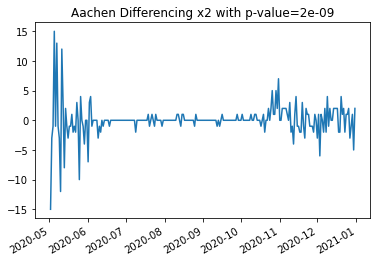

In [7]:
# Taking the difference once more to see if it gives better results
aachen_stationary_x2 = aachen.diff().diff().dropna()
adf_test(aachen_stationary_x2['faelle_covid_aktuell_beatmet'])
plt.plot(aachen_stationary.faelle_covid_aktuell_beatmet)
plt.title("Aachen Differencing x2 with p-value=2e-09")
plt.gcf().autofmt_xdate()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.019585e+01
p-value                        6.149395e-18
#Lags Used                     2.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64
p-value: 6.1493946004469735e-18 < 0.05 => the series is stationary


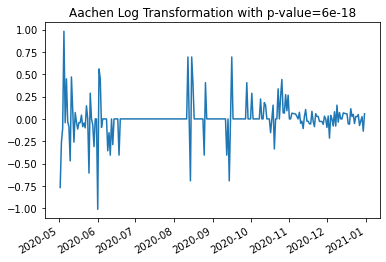

In [8]:
# log transformation
aachen_log = np.log(aachen/aachen.shift(1))
# preprocessing
aachen_log = aachen_log.drop(aachen_log.index[0])
aachen_log = aachen_log.replace([np.inf, -np.inf, np.nan], 0)
# run an augmented Dicky-Fuller test
adf_test(aachen_log['faelle_covid_aktuell_beatmet'])
plt.plot(aachen_log.faelle_covid_aktuell_beatmet)
plt.title("Aachen Log Transformation with p-value=6e-18")
plt.gcf().autofmt_xdate()
plt.show()

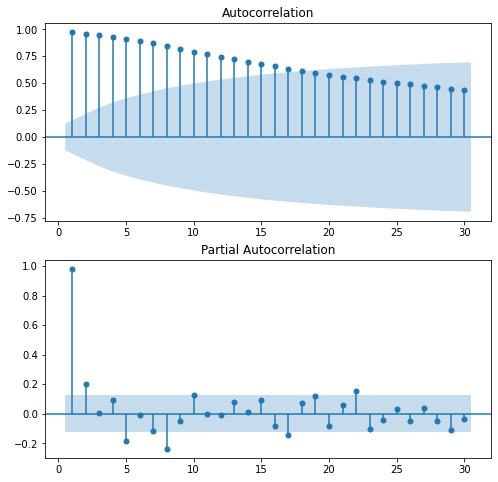

In [9]:
# Using ACF and PACF to choose model order
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
# Make ACF plot
plot_acf(aachen.faelle_covid_aktuell_beatmet, lags=30, zero=False, ax=ax1)
# Make PACF plot
plot_pacf(aachen.faelle_covid_aktuell_beatmet, lags=30, zero=False, ax=ax2)

plt.show()


C:\Users\filip\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\filip\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


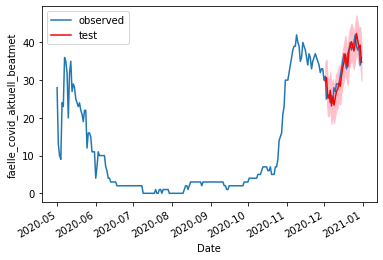

In [10]:
# Based on ACF and PACF plots we decide on a ARIMA(8,1,0) model
model = SARIMAX(aachen.faelle_covid_aktuell_beatmet, order=(8,1,0))
results = model.fit()
# Test the model on the last 30 days
forecast = results.get_prediction(start=-30)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
# set confidence interval
lower_limits = confidence_intervals.loc[:,'lower faelle_covid_aktuell_beatmet']
upper_limits = confidence_intervals.loc[:,'upper faelle_covid_aktuell_beatmet']
# plot results
plt.plot(aachen.index, aachen.faelle_covid_aktuell_beatmet, label='observed')
plt.plot(mean_forecast.index, mean_forecast, color = 'red', label='test')
plt.fill_between(lower_limits.index,lower_limits , upper_limits, color='pink')
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('faelle_covid_aktuell_beatmet')
plt.legend(loc = 'upper left')

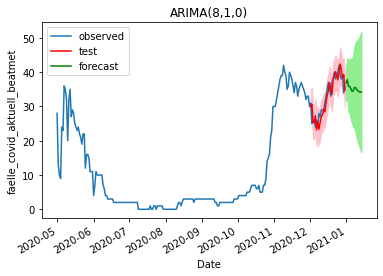

In [11]:
# forecast for the next 14 days
arima_value_forecast = results.get_forecast(steps=14)
arima_mean_forecast = arima_value_forecast.predicted_mean
forecast_confidence_intervals = arima_value_forecast.conf_int()
# set confidence interval
forecast_lower_limits = forecast_confidence_intervals.loc[:,'lower faelle_covid_aktuell_beatmet']
forecast_upper_limits = forecast_confidence_intervals.loc[:,'upper faelle_covid_aktuell_beatmet']

# plot everything
plt.plot(aachen.index, aachen.faelle_covid_aktuell_beatmet, label='observed')
plt.plot(mean_forecast.index, mean_forecast, color = 'red', label='test')
plt.fill_between(lower_limits.index,lower_limits , upper_limits, color='pink')
plt.plot( arima_mean_forecast.index, arima_mean_forecast, color = 'green', label='forecast')
plt.fill_between(forecast_lower_limits.index,forecast_lower_limits , forecast_upper_limits, color='lightgreen')
plt.gcf().autofmt_xdate()
plt.title('ARIMA(8,1,0)')
plt.xlabel('Date')
plt.ylabel('faelle_covid_aktuell_beatmet')
plt.legend(loc = 'upper left')
plt.show()